<a href="https://colab.research.google.com/github/Francesca-Rossi/ITA_university_advisor/blob/main/Italian_university_advisor_backup_14_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importazione librerie

In [959]:
import gspread 
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import os
from oauth2client.service_account import ServiceAccountCredentials
from google.colab import drive
from nltk.corpus import stopwords
from nltk.stem.snowball import ItalianStemmer
import json as js


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Funzioni principali

In [960]:
stop_ita = stopwords.words('italian')
stop_en = stopwords.words('english')
stemmer = ItalianStemmer()


#CLEANING DATA
def lang_stop_words(feature, lang):
  if (lang == "IT"):
    feature=feature.apply(lambda x: [item for item in x if item not in stop_ita]) 
  elif (lang == "EN"):
    feature=feature.apply(lambda x: [item for item in x if item not in stop_en]) 
  else:
    feature=feature.apply(lambda x: [item for item in x if item not in stop_ita])
    feature=feature.apply(lambda x: [item for item in x if item not in stop_en])
  return feature

def data_cleaning(feature, regex_list):
  feature=feature.apply(lambda x: x.lower()) #minuscolo
  feature=feature.str.strip() #eliminaz spazi bianchi inizio e fine
  for regex in regex_list:
    feature=feature.str.replace(regex, ' ')
    #feature=feature.str.replace(r'\s\s+', ' ') #eliminaz doppi spazi
  for char in string.punctuation:
    feature=feature.str.replace(char, ' ')
  return feature

#PREPROCESSING TEXT
def preprocessing_text(dataframe, feature, key, lang): 
  feature=feature.str.strip() #elimino spazi bianchi a inizio e fine
  feature =dataframe.apply(lambda row: nltk.word_tokenize(row[key]), axis=1)
  feature =lang_stop_words(feature, lang)
  feature=feature.apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word
  feature=feature.apply(' '.join)
  return feature

#FEATURE ENGINEERING
def tf_vector(vectorize, feature):
  tf_matrix = vectorize.fit_transform(feature)
  tf_matrix = tf_matrix.toarray()
  vocab = vectorize.get_feature_names()
  return pd.DataFrame(np.round(tf_matrix, 2), columns=vocab)

#GRAPHS
# missing value
def missing_value_colors(values, tot):
  clrs=[]
  for x in values:
    x_perc= (x/tot)*100
    if (x_perc<=75):
      clrs.append('g') #green when missing value < 75%
    elif (x_perc>75) and (x_perc<=85):
      clrs.append('y')
    else:
      clrs.append('r')
  return clrs

def missing_value_graphs(dataframe_missing_value, original_df, title):
  #variable
  tot_values=original_df.shape[0] 
  print(tot_values)
  values=dataframe_missing_value.values
  row_index=dataframe_missing_value.index
  start=0
  for i in range(2, 0, -1):
    end=int(len(row_index)/i)
    title_str=f'{title} missing values from {row_index[start]} to {row_index[end-1]}'
    #graphs
    fig, ax = plt.subplots(figsize =(10, 12))
    colors=missing_value_colors(values, tot_values)
    ax.barh(row_index[start:end], values[start:end], color=colors[start:end])   # Horizontal Bar Plot
    ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)   # Add x, y gridlines
    for i in ax.patches: 
        plt.text(i.get_width()+0.2, i.get_y()+0.5,str(round(((i.get_width()/tot_values)*100), 2))+'%',
                fontsize = 10, fontweight ='bold',color ='grey')   # Add annotation to bars
    ax.invert_yaxis()   # Show top values
    #labeling
    plt.xlabel("Missing values")
    plt.ylabel("Features")
    plt.title(title_str)
    plt.show() #show the graphs
    start=end



#COLLEGAMENTO CON IL GOOGLE SHEET 

In [961]:
SCOPES = ["https://spreadsheets.google.com/feeds",
                  "https://www.googleapis.com/auth/spreadsheets",
                  "https://www.googleapis.com/auth/drive",
                  "https://www.googleapis.com/auth/drive"]
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/big data proj")
cred = ServiceAccountCredentials.from_json_keyfile_name("/content/drive/My Drive/Colab Notebooks/big data proj/GoogleSheetCredentials.json", SCOPES)
gclient = gspread.authorize(cred)
sheet = gclient.open_by_url("https://docs.google.com/spreadsheets/d/1scMc0UlNC1pdZNow5k3pLhofcW6j4ekXyxYlNiBcueI/edit?usp=sharing")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# RECUPERO FOGLI E SALVATAGGIO IN DATAFRAME

In [962]:
students_data = sheet.worksheet('Laureando').get_all_records()
graduate_data = sheet.worksheet('Laureato').get_all_records()

In [963]:
df_students = pd.DataFrame(students_data)
df_graduate = pd.DataFrame(graduate_data)
print("students shape:", df_students.shape )
print("graduates shape:", df_graduate.shape )

students shape: (719, 88)
graduates shape: (61, 85)


##RIMOZIONE FEATURES RELATIVE AD UN ALTRO PROGETTO

In [964]:
df_students = df_students.drop(df_students.loc[:, 'degree_course_class':'decision_choice_class'].columns, axis=1)
df_graduate = df_graduate.drop(df_graduate.loc[:, 'degree_course_class':'decision_choice_class'].columns, axis=1)
print("students shape:", df_students.shape )
print("graduates shape:", df_graduate.shape )

students shape: (719, 79)
graduates shape: (61, 76)


#ANALISI VALORI MANCANTI

##Sostituzione celle vuote con valore 'Nan'

In [965]:
df_students=df_students.replace('',np.NaN)
df_graduate=df_graduate.replace('',np.NaN)

##Somma valori mancanti per ogni features

In [966]:
df_missing_value_students=df_students.isnull().sum()
df_missing_value_graduate=df_graduate.isnull().sum()

##STUDENTI: grafico valori mancanti

719


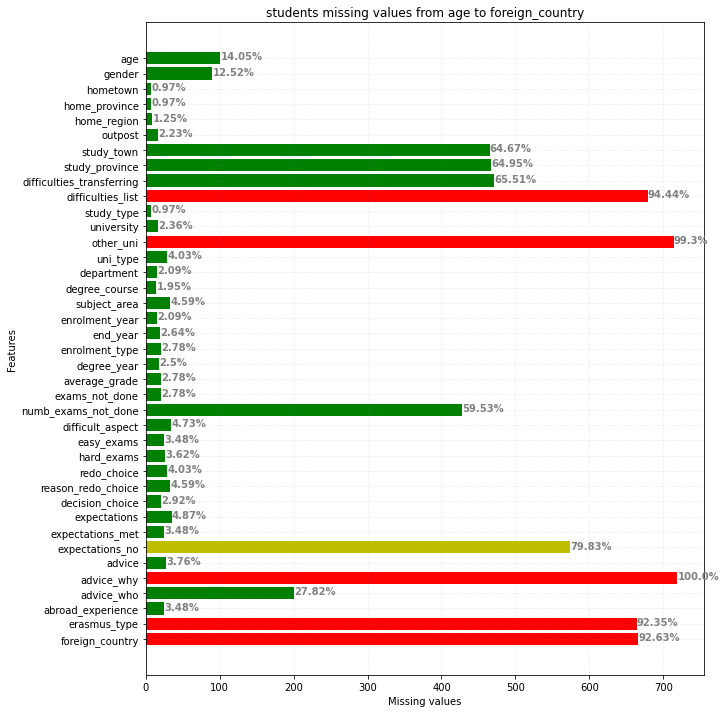

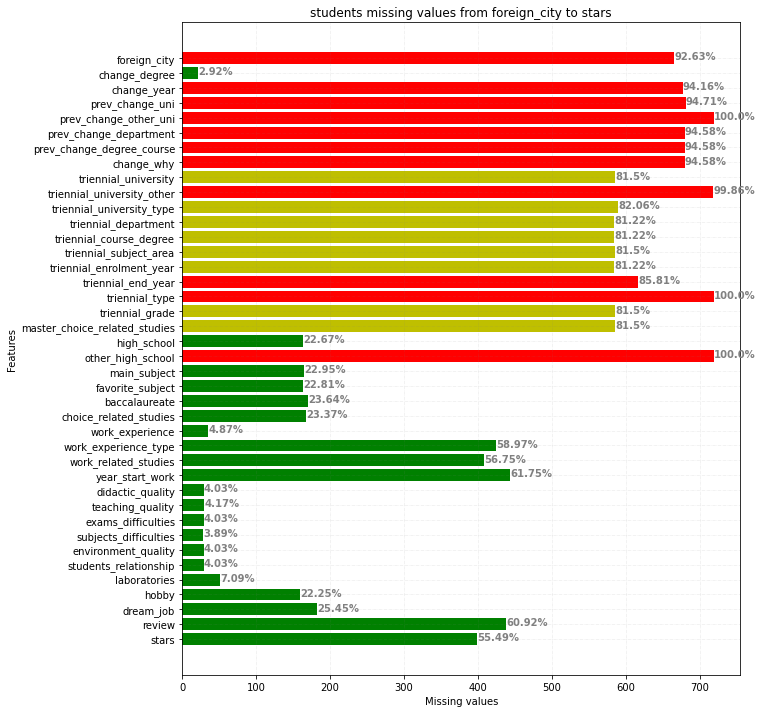

In [967]:
missing_value_graphs(df_missing_value_students, df_students, 'students')

##LAUREATI: grafico valori mancanti

61


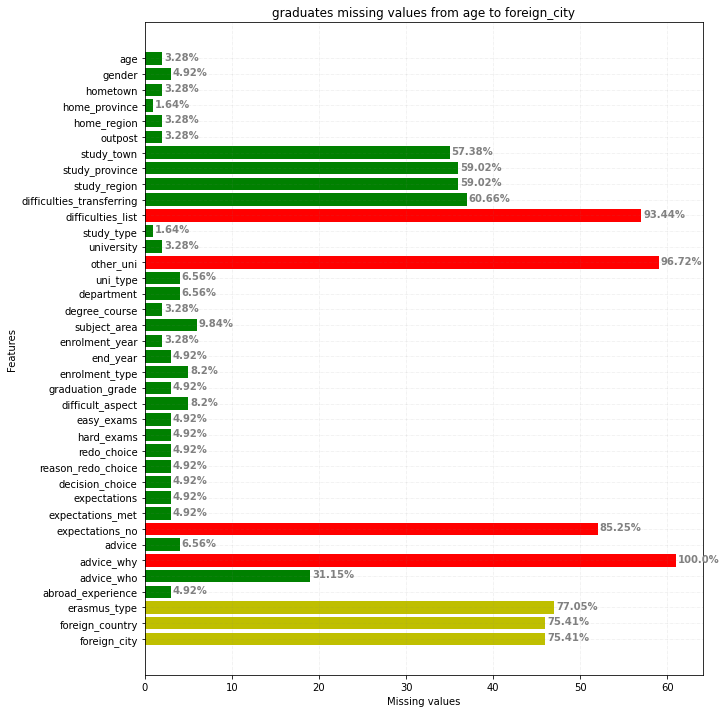

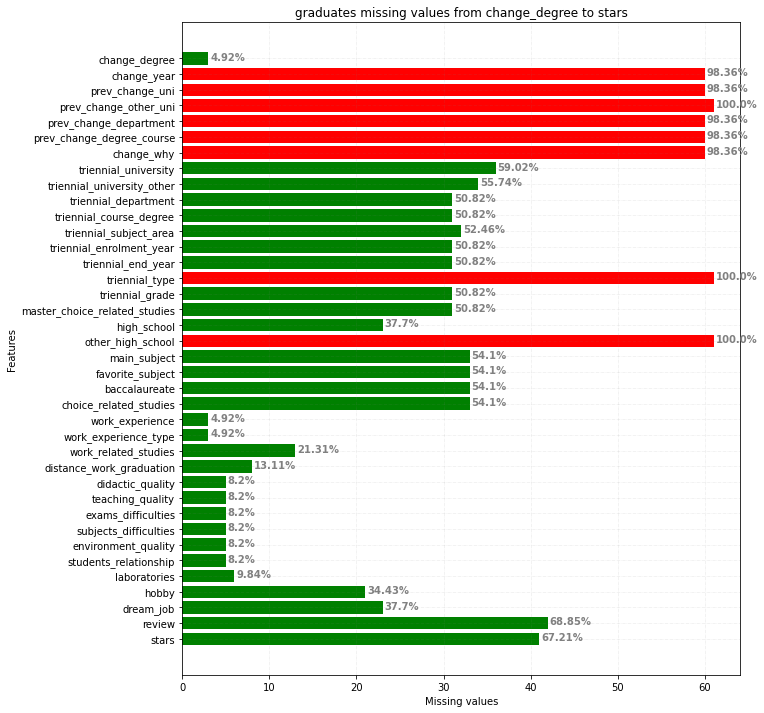

In [968]:
missing_value_graphs(df_missing_value_graduate, df_graduate, 'graduates')

#GESTIONE VALORI MANCANTI NELLA COLONNA UNIVERSITA'

##Studenti

###1 - Sostituzione altro con valore 'Nan'

In [969]:
df_students['university']=df_students['university'].replace('altro', np.NaN ) #necessario per effettuare merge tra 2 colonne
df_students.shape

(719, 79)

In [970]:
#TODO remove [fra]
df_students[['university', 'other_uni']].head(50) #codice di controllo

,university,other_uni
0,Politecnico di MILANO,NaN
1,Università degli Studi di NAPOLI Federico II,NaN
2,Università degli Studi di ROMA La Sapienza,NaN
3,Università degli Studi di ROMA La Sapienza,NaN
4,Università degli Studi di CAGLIARI,NaN
5,Università degli Studi di PARMA,NaN
6,NaN,"Civica Scuola di Cinema ""Luchino Visconti"""
7,Università degli Studi di BOLOGNA,NaN
8,Università degli Studi di PARMA,NaN
9,Università degli Studi di PARMA,NaN


###2- Merge tra la colonna university e other_uni per unire i valori mancanti in university

In [971]:
df_students['university']=df_students['university'].combine_first(df_students['other_uni'])
#df_students['university'].head(50)

### 3 - Eliminazione delle righe che nonostante il merge presentano valori nulli nella colonna university

In [972]:
df_students = df_students[df_students['university'].notna()]
df_students.shape

(696, 79)

##Laureati

### 1- Sostituzione altro con il valore 'Nan'

In [973]:

df_graduate['university']=df_graduate['university'].replace('altro', np.NaN ) #per poter fare il merge tra due colonne
df_graduate.shape

(61, 76)

In [974]:
#TODO remove [fra]
df_graduate.isnull().sum() #codice di controllo

age               2
gender            3
hometown          2
home_province     1
home_region       2
                 ..
laboratories      6
hobby            21
dream_job        23
review           42
stars            41
Length: 76, dtype: int64

In [975]:
#TODO remove [fra]
df_graduate[['university', 'other_uni']].head(50) #codice di controllo

,university,other_uni
0,Università degli Studi di PARMA,NaN
1,Università degli Studi di PARMA,NaN
2,Università degli Studi di PARMA,NaN
3,Università degli Studi di PARMA,NaN
4,Università degli Studi di VERONA,NaN
5,Università degli Studi di MODENA e REGGIO EMILIA,NaN
6,Università degli Studi di PARMA,NaN
7,Università degli Studi di NAPOLI Federico II,NaN
8,Università degli Studi di PADOVA,NaN
9,Università degli Studi di ROMA Foro Italico,NaN


### 2- Merge tra colonna university e other_uni

In [976]:
df_graduate['university']=df_graduate['university'].combine_first(df_graduate['other_uni'])
#df_graduate['university'].head(50)

###3- Eliminazione delle righe che contengono ancora 'Nan' nella colonna university

In [977]:
df_graduate = df_graduate[df_graduate['university'].notna()]
df_graduate.shape

(57, 76)

#DATI TRIENNALE E MAGISTRALE CICLO UNICO

<p>Selezionare le righe secondo una determinata condizione</p>
<a href="https://chrisalbon.com/python/data_wrangling/pandas_selecting_rows_on_conditions/"> https://chrisalbon.com/python/data_wrangling/pandas_selecting_rows_on_conditions/</a>

In [978]:
query_first_degree='study_type == "Triennale" | study_type == "Magistrale_unico"'
df_students_first_degree = df_students.query(query_first_degree)
df_graduate_first_degree = df_graduate.query(query_first_degree)
print('students first degree:',df_students_first_degree.shape)
print('graduates first degree:',df_graduate_first_degree.shape)


students first degree: (557, 79)
graduates first degree: (27, 76)


##ANALISI VALORI MANCANTI

In [979]:
df_missing_value_first_degree_students=df_students_first_degree.isnull().sum()
df_missing_value_first_degree_graduate=df_graduate_first_degree.isnull().sum()

###STUDENTI TRIENNALE E MAISTRALE A CICLO UNICO:grafico valori mancanti

557


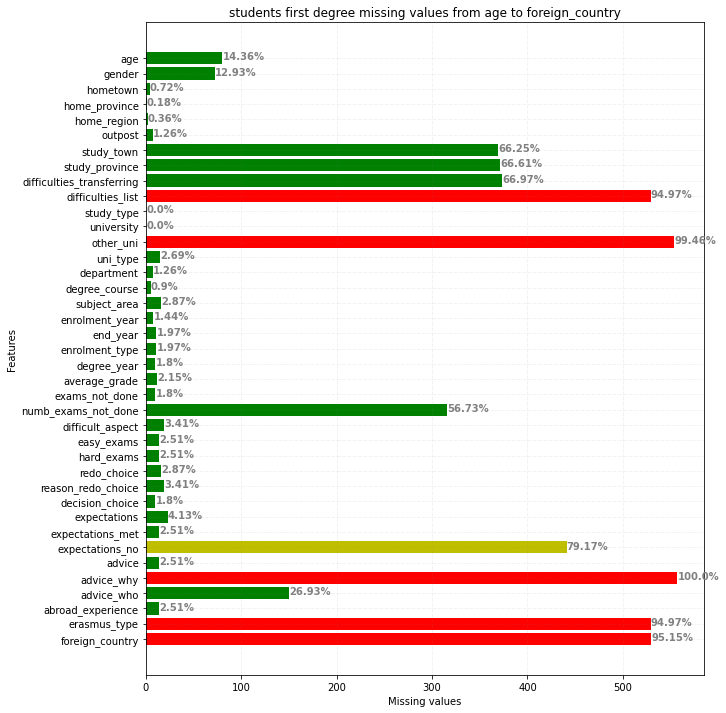

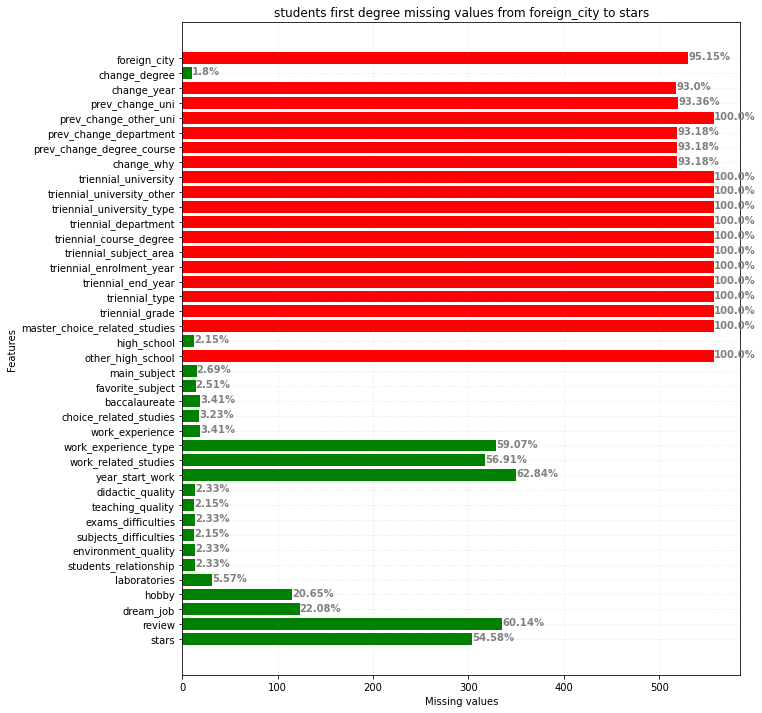

In [980]:
missing_value_graphs(df_missing_value_first_degree_students, df_students_first_degree, 'students first degree')

###LAUREATI TRIENNALE E MAGISTRALE A CICLO UNICO:grafico valori mancanti

27


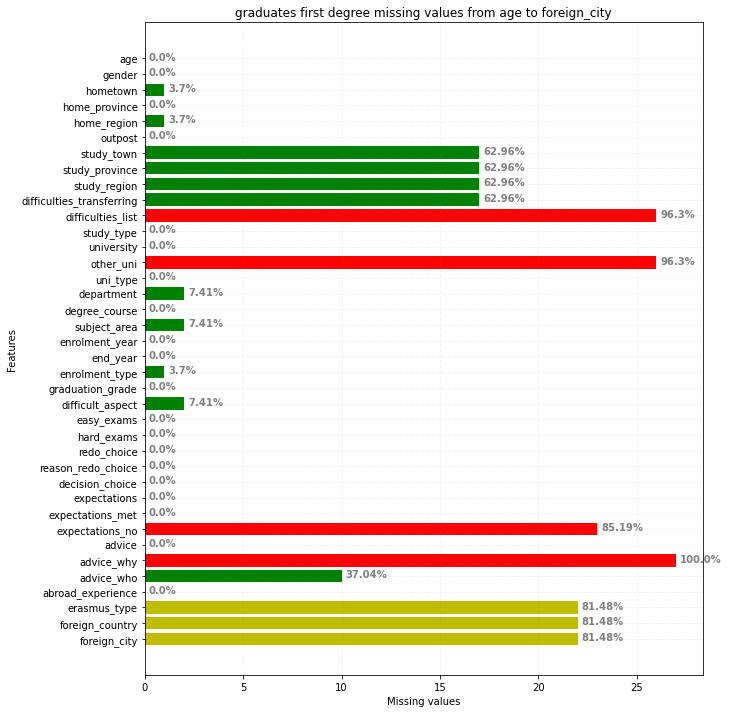

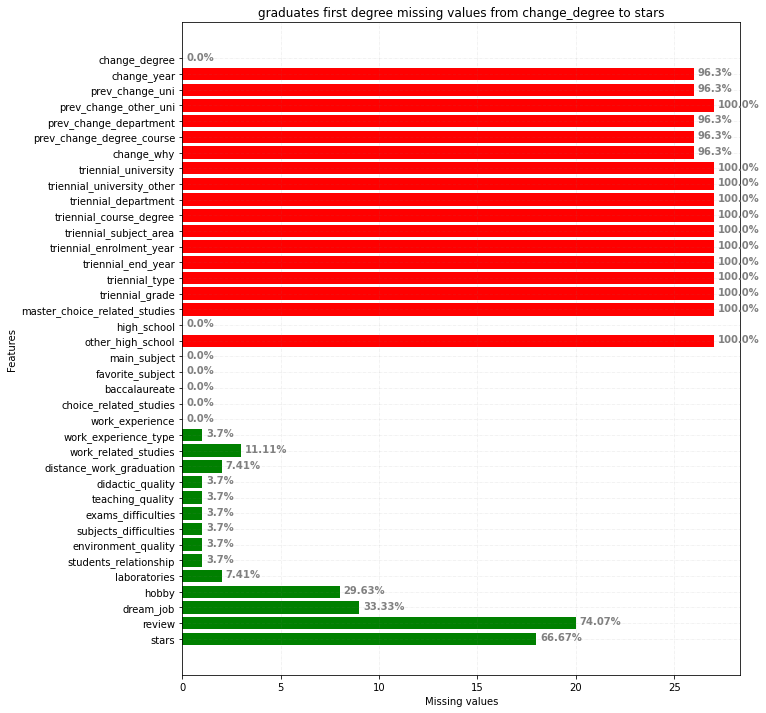

In [981]:
missing_value_graphs(df_missing_value_first_degree_graduate, df_graduate_first_degree, 'graduates first degree')

##FEATURES SELECTION

In [982]:
features_first_degree=['degree_course','other_high_school','high_school','main_subject', 'favorite_subject', 'dream_job', 'hobby', 'decision_choice' , 'expectations', 'choice_related_studies'  ]

##Unisco sia gli studenti che i laurati per le feature che ci interessano

In [983]:
all_features_dict={}
for feature in features_first_degree:
  all_features=df_students_first_degree[feature]
  all_features=all_features.append(df_graduate_first_degree[feature], ignore_index=True, verify_integrity=True)
  all_features_dict[feature]=all_features

df_all_features_first_degree=pd.DataFrame(all_features_dict)
print('total sample firt degree:',df_all_features_first_degree.shape[0] )
df_all_features_first_degree.head()

total sample firt degree: 584


,degree_course,other_high_school,high_school,main_subject,favorite_subject,dream_job,hobby,decision_choice,expectations,choice_related_studies
0,ingegneria aerospaziale,NaN,Liceo Scientifico,"Scienze,matematica,informatica",matematica,CERN o ASI,"Astronomia,musica","Passioni personali (spazio, meccanica, aerei etc)",NaN,SI
1,Economia e commercio,NaN,Liceo Scientifico,"matematica,fisica,scienze",matematica,consulente finanziario,videogiochi,la mia voglia di intraprendere questo percorso...,quello che sto vivendo,NO
2,Medicina,NaN,Liceo Classico,"Greco, latino,italiano",Non ne avevo una,Radiologo,"Ascoltare musica, vedere film",La predisposizione alla materia,Di riuscire a proseguire con facilità,NO
3,Medicina e chirurgia,NaN,Liceo Classico,"Latino, greco, italiano",Latino,Diventare un medico specializzato,Atletica,Ho sempre voluto fare questo mestiere,Sicuramente lungo e faticoso ma spero soddisfa...,NO
4,Infermieristica,NaN,Liceo Classico,"Greco, latino, italiano, letteratura, filosofia.",Filosofia,Infermiere di sala operatoria,"Musica (batteria), biliardo.",Il desiderio di poter dare una mano a chi ne h...,Tutto quello che ho effettivamente incontrato ...,NO


##CLEANING TARGET VARIABLE (degree_course)

In [984]:
#acronimi
slang_degree_course={"ctf":"chimica e tecnologie farmaceutiche",
       "clemi": "economia e marketing internazionale", 
       "sztpa": "scienze zootecniche e tecnologie delle produzioni animali", 
       "smid": "statistica matematica e trattamento informatico dati", 
       "clei": "economia internazionale",
       "clem": "economia e marketing", 
       "cle": "economia", 
       "dams": "discipline delle arti della musica e dello spettacolo",
       "ctc": "chimica e tecnologie chimiche",
       "pmts": "planning management of tourism systems",
       "eifi":  "lingue moderne comunicazione cooperazione internazionale",
       "lms":  "letteratura musica spettacolo"
        }
regex_degree_course=[r'\sl.*[0-9]+', r'\scurriculum\s.*', r'indirizzo.*', r'[(].*[)]*', r'&', r'\s\s+', r'corso di laurea', r'ciclo unico', r'’']

###eliminazione valori nulli da degree course

In [985]:
df_all_features_first_degree=df_all_features_first_degree[df_all_features_first_degree['degree_course'].notna()]

###Cleaning valori

In [986]:
df_all_features_first_degree['degree_course']=data_cleaning(df_all_features_first_degree['degree_course'], regex_degree_course)
#sostituzione slang
for key in slang_degree_course.keys():
  df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains(key), 'degree_course'] = slang_degree_course[key]

#ulteriore pulizia manuale
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('medicina') & ~df_all_features_first_degree['degree_course'].str.contains('veterinaria'), 'degree_course'] = 'medicina e chirurgia'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('informatica') & df_all_features_first_degree['degree_course'].str.contains('elettronica') & df_all_features_first_degree['degree_course'].str.contains('telecomunicazioni') , 'degree_course'] = 'ingegneria informatica elettronica e telecomunicazioni'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('comunicazione e media per le industrie creative'), 'degree_course'] = 'comunicazione e media contemporanei per le industrie creative'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('elettronica') & ~df_all_features_first_degree['degree_course'].str.contains('ingegneria' )& ~df_all_features_first_degree['degree_course'].str.contains('ing'), 'degree_course'] = 'ingegneria elettronica'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('interfacce e tecnologie della comunicazion'), 'degree_course'] = 'interfacce uomo macchina e tecnologie della comunicazione'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('letteratura musica e spettacolo'), 'degree_course'] = 'letteratura musica e spettacolo'
df_all_features_first_degree['degree_course']=df_all_features_first_degree['degree_course'].str.replace(r'(^ingegneria\s*)|(^ingegneria)', 'ing ')
df_all_features_first_degree['degree_course']=df_all_features_first_degree['degree_course'].str.replace('ingeneria ', 'ing ')
df_all_features_first_degree['degree_course']

0                 ing aerospaziale
1             economia e commercio
2             medicina e chirurgia
3             medicina e chirurgia
4                  infermieristica
                  ...             
579                           ing 
580           medicina e chirurgia
581                scienze motorie
582               servizio sociale
583    beni culturali e spettacolo
Name: degree_course, Length: 579, dtype: object

In [987]:
df_all_features_first_degree['degree_course']=preprocessing_text(df_all_features_first_degree, df_all_features_first_degree['degree_course'], 'degree_course', 'IT-EN')

In [988]:
unique_degree_course=np.unique(df_all_features_first_degree['degree_course'])
print(len(unique_degree_course))
print(unique_degree_course)

178
['amministr finanz' 'archeolog' 'architettur' 'arti scienz spettacol'
 'autom industrial' 'banc finanz' 'ben artist spettacol' 'ben cultural'
 'ben cultural spettacol' 'biolog' 'biolog molecol' 'biotecnolog' 'chimic'
 'chimic tecnolog chimic' 'chimic tecnolog farmaceut'
 'civilt lingu stran mod' 'comun' 'comun med contemporane industr creativ'
 'comun med pubblic' 'cultur digital comun' 'design'
 'design prodott industrial' 'design prodott nautic' 'dietist'
 'digital marketing' 'direzion impres' 'diritt econom' 'diritt tecnolog'
 'disciplin arti music spettacol' 'econom' 'econom amministr impres'
 'econom aziendal' 'econom commerc' 'econom finanz'
 'econom gestion aziendal' 'econom internazional' 'econom management'
 'econom management nuov tecnolog digital' 'econom marketing'
 'econom marketing internazional' 'econom marketing management'
 'econom merc digital' 'econom merc istitu' 'economics markets financ'
 'economì management' 'electronic communications engineering' 'farmac'
 '

##FEATURE ENGINEERING DEGREE COURSE

In [989]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
vectorize_matrix=tf_vector(tv, df_all_features_first_degree['degree_course'])
vectorize_matrix

,aerospazial,agrar,alimentar,ambient,ambiental,amministr,animal,archeolog,architettur,arti,artist,autom,aziendal,banc,ben,biolog,biomed,biotecnolog,chimic,chirurg,cinematograf,civil,civilt,cognit,commerc,communications,compar,comun,contemporane,costruzion,creativ,cultur,cultural,dat,dental,dentar,design,dietist,digital,direzion,...,primar,process,prodott,produzion,profession,progett,protes,psicog,psicolog,pubblic,radiolog,radioterap,relazion,sal,sanitar,scienz,serviz,sistem,social,sociolog,spettacol,sport,statist,stor,stran,stud,system,tecnic,tecnolog,telecomun,televis,traduzion,tratt,turism,tutel,uman,uom,veicol,veterinar,zootecn
0,0.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.71,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.71,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
575,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.71,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
576,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.37,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
577,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.72,0.0,0.69,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [990]:
similarity_matrix = cosine_similarity(vectorize_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.178186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.249879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.192934,0.0,0.0,0.0,0.0,0.192934,0.158507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.121227,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.378245,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.40627,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.292619,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.475741,0.0,0.0,0.0,0.000000,0.000000,0.0,0.275328,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.292619,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,1.0,0.000000,0.344534,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.344534,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,1.0,0.000000,0.344534,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.344534,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.882075,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [991]:
km = KMeans(n_clusters=150)
km.fit_transform(similarity_df)
cluster_labels = km.labels_
cluster_labels_degree_course = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
df_all_features_first_degree= df_all_features_first_degree.set_index(cluster_labels_degree_course.index) #evita che escano valori NAN a causa di index diversi
cluster_labels_degree_course.insert(0,'degree_course',df_all_features_first_degree['degree_course'], True)
byCluster=cluster_labels_degree_course.groupby(['ClusterLabel'])

In [1043]:

for cluster, degree in byCluster:
    print(f"All entries for {cluster!r}")
    print("------------------------")
    print(degree, end="\n\n")   #display(degree)

All entries for 0
------------------------


,degree_course,ClusterLabel
22,ing elettron informat,0
50,ing elettron informat,0
136,ing elettron informat,0
533,ing elettron informat,0


All entries for 1
------------------------


,degree_course,ClusterLabel
39,economics markets financ,1
476,dietist,1


All entries for 2
------------------------


,degree_course,ClusterLabel
2,medicin chirurg,2
3,medicin chirurg,2
8,medicin chirurg,2
11,medicin chirurg,2
12,medicin chirurg,2
13,medicin chirurg,2
23,medicin chirurg,2
37,medicin chirurg,2
53,medicin chirurg,2
55,medicin chirurg,2


All entries for 3
------------------------


,degree_course,ClusterLabel
394,psicolog,3


All entries for 4
------------------------


,degree_course,ClusterLabel
29,scienz biolog,4
68,scienz biolog,4
95,scienz biolog,4
134,scienz biolog,4
145,scienz biolog,4
227,scienz biolog,4
276,scienz biolog,4
381,scienz biolog,4
408,scienz biolog,4
438,scienz biolog,4


All entries for 5
------------------------


,degree_course,ClusterLabel
215,econom marketing management,5


All entries for 6
------------------------


,degree_course,ClusterLabel
32,informat,6
41,informat,6
59,informat,6
96,informat,6
98,informat,6
114,informat,6
118,informat,6
137,informat,6
147,informat,6
149,informat,6


All entries for 7
------------------------


,degree_course,ClusterLabel
34,scienz zootecn tecnolog produzion animal,7
38,scienz zootecn tecnolog produzion animal,7
71,scienz zootecn tecnolog produzion animal,7
79,scienz zootecn tecnolog produzion animal,7
87,scienz zootecn produzion animal,7
106,scienz zootecn tecnolog produzion animal,7
133,scienz zootecn tecnolog produzion animal,7
235,scienz zootecn tecnolog produzion animal,7
325,scienz zootecn tecnolog produzion animal,7
332,scienz zootecn tecnolog produzion animal,7


All entries for 8
------------------------


,degree_course,ClusterLabel
20,giurisprudt,8
62,giurisprudt,8
72,giurisprudt,8
110,giurisprudt,8
181,giurisprudt,8
193,giurisprudt,8
218,giurisprudt,8
251,giurisprudt,8
290,giurisprudt,8
342,giurisprudt,8


All entries for 9
------------------------


,degree_course,ClusterLabel
88,ing gestional,9
185,ing gestional,9
189,ing gestional,9
209,ing gestional,9
223,ing gestional,9
237,ing gestional,9
402,ing gestional,9
416,ing gestional,9
421,ing gestional,9
430,ing gestional,9


All entries for 10
------------------------


,degree_course,ClusterLabel
216,lingu cultur europe,10
239,lingu cultur europe,10
252,lingu cultur europe,10
279,lingu cultur europe,10
543,lingu cultur europe,10


All entries for 11
------------------------


,degree_course,ClusterLabel
0,ing aerospazial,11
97,ing energ,11
435,ing veicol,11


All entries for 12
------------------------


,degree_course,ClusterLabel
73,arti scienz spettacol,12


All entries for 13
------------------------


,degree_course,ClusterLabel
4,infermierist,13
86,infermierist,13
100,infermierist,13
116,infermierist,13
225,infermierist,13
228,infermierist,13
267,infermierist,13
277,infermierist,13
407,infermierist,13
474,infermierist,13


All entries for 14
------------------------


,degree_course,ClusterLabel
139,ben cultural,14
345,ben cultural,14
361,ben cultural,14
434,ben cultural,14


All entries for 15
------------------------


,degree_course,ClusterLabel
31,ing informat,15
40,ing informat,15
42,ing informat,15
45,ing informat,15
94,ing informat,15
120,ing informat,15
121,ing informat,15
142,ing informat,15
160,ing informat,15
186,ing informat,15


All entries for 16
------------------------


,degree_course,ClusterLabel
125,scienz tecnolog alimentar,16
156,scienz tecnolog alimentar,16
182,scienz tecnolog alimentar,16
194,scienz tecnolog alimentar,16
262,scienz tecnolog alimentar,16
328,scienz tecnolog alimentar,16
343,scienz tecnolog alimentar,16
431,scienz tecnolog alimentar,16
499,scienz tecnolog alimentar,16


All entries for 17
------------------------


,degree_course,ClusterLabel
67,scienz psicog,17
184,scienz eduz,17
448,scienz geolog,17


All entries for 18
------------------------


,degree_course,ClusterLabel
213,chimic,18
278,chimic,18
285,chimic tecnolog chimic,18
365,chimic,18
376,chimic,18
378,chimic,18


All entries for 19
------------------------


,degree_course,ClusterLabel
76,ing sistem inform,19
115,ing sistem inform,19
131,ing sistem inform,19
132,ing sistem inform,19
210,ing sistem inform,19
270,ing sistem inform,19
351,ing sistem inform,19
362,ing sistem inform,19
372,ing sistem inform,19
406,ing sistem inform,19


All entries for 20
------------------------


,degree_course,ClusterLabel
51,scienz comun,20
54,scienz comun,20
152,scienz comun,20
164,scienz comun,20
183,scienz comun,20
314,scienz comun,20
386,scienz comun,20
443,scienz comun,20
505,scienz comun,20


All entries for 21
------------------------


,degree_course,ClusterLabel
60,econom aziendal,21
167,econom aziendal,21
370,econom aziendal,21
423,econom aziendal,21
456,econom aziendal,21
457,econom aziendal,21
484,econom aziendal,21
538,econom aziendal,21
571,econom aziendal,21


All entries for 22
------------------------


,degree_course,ClusterLabel
75,scienz tecnic psicolog,22
122,scienz tecnic psicolog,22
130,scienz tecnic psicolog,22
151,scienz tecnic psicolog,22
166,scienz tecnic psicolog,22
190,scienz tecnic psicolog,22
221,scienz tecnic psicolog,22
260,scienz tecnic psicolog,22
271,scienz tecnic psicolog,22
293,scienz tecnic psicolog,22


All entries for 23
------------------------


,degree_course,ClusterLabel
52,fisic,23
99,fisic,23
104,fisic,23
105,fisic,23
124,fisic,23
211,fisic,23
497,fisic,23
504,fisic,23
516,fisic,23
518,fisic,23


All entries for 24
------------------------


,degree_course,ClusterLabel
92,econom marketing internazional,24
102,econom marketing internazional,24
119,econom marketing internazional,24
236,econom marketing internazional,24
242,econom marketing internazional,24
244,econom marketing internazional,24
292,econom marketing internazional,24
312,econom marketing internazional,24
526,econom marketing internazional,24
528,econom marketing internazional,24


All entries for 25
------------------------


,degree_course,ClusterLabel
101,civilt lingu stran mod,25
229,civilt lingu stran mod,25
254,civilt lingu stran mod,25
286,civilt lingu stran mod,25


All entries for 26
------------------------


,degree_course,ClusterLabel
93,ing elettron,26
200,ing elettron,26
470,ing elettron,26
501,ing elettron,26


All entries for 27
------------------------


,degree_course,ClusterLabel
316,scienz educ process format,27
327,scienz educ process format,27
329,scienz educ process format,27
374,scienz educ process format,27
427,scienz educ process format,27
503,scienz educ process format,27
523,scienz educ process format,27


All entries for 28
------------------------


,degree_course,ClusterLabel
46,mediazion linguist intercultural,28
47,mediazion linguist intercultural,28
140,mediazion linguist intercultural,28
161,mediazion linguist intercultural,28
173,mediazion linguist intercultural,28
355,mediazion interlinguist intercultural,28
357,mediazion linguist intercultural,28
532,mediazion linguist,28


All entries for 29
------------------------


,degree_course,ClusterLabel
7,digital marketing,29
126,digital marketing,29
449,digital marketing,29
458,digital marketing,29
459,digital marketing,29


All entries for 30
------------------------


,degree_course,ClusterLabel
154,econom,30
245,econom,30
258,econom,30
363,econom,30
420,econom,30
440,econom,30
475,econom,30


All entries for 31
------------------------


,degree_course,ClusterLabel
26,biotecnolog,31
69,biotecnolog,31
171,biotecnolog,31
191,biotecnolog,31
382,biotecnolog,31
461,biotecnolog,31
463,biotecnolog,31


All entries for 32
------------------------


,degree_course,ClusterLabel
111,serviz social,32
203,serviz social,32
403,serviz social,32
553,serviz social,32
567,serviz social,32
577,serviz social,32


All entries for 33
------------------------


,degree_course,ClusterLabel
176,farmac,33
265,farmac,33
326,farmac,33
353,farmac,33
424,farmac,33
487,farmac,33


All entries for 34
------------------------


,degree_course,ClusterLabel
123,lett mod,34
284,lett mod,34
318,lett mod,34
377,lett mod,34
404,lett mod,34


All entries for 35
------------------------


,degree_course,ClusterLabel
44,biolog,35
177,biolog,35
201,biolog,35
309,biolog,35
366,biolog,35
397,biolog,35
522,biolog,35
561,biolog,35


All entries for 36
------------------------


,degree_course,ClusterLabel
63,ing meccan,36
197,ing meccan,36
256,ing meccan,36
303,ing meccan,36
512,ing meccan,36
530,ing meccan,36


All entries for 37
------------------------


,degree_course,ClusterLabel
112,econom finanz,37
162,econom finanz,37
359,econom finanz,37
472,econom finanz,37
562,econom finanz,37


All entries for 38
------------------------


,degree_course,ClusterLabel
15,scienz polit,38
128,scienz polit,38
387,scienz polit,38


All entries for 39
------------------------


,degree_course,ClusterLabel
33,design prodott nautic,39
545,design,39


All entries for 40
------------------------


,degree_course,ClusterLabel
58,ing informat elettron telecomun,40
66,ing informat elettron telecomun,40
157,ing informat elettron telecomun,40
178,ing informat elettron telecomun,40
207,ing informat elettron telecomun,40
250,ing informat elettron telecomun,40
294,ing informat elettron telecomun,40
301,ing informat elettron telecomun,40
379,ing informat elettron telecomun,40
383,ing informat elettron telecomun,40


All entries for 41
------------------------


,degree_course,ClusterLabel
261,chimic tecnolog farmaceut,41
296,chimic tecnolog farmaceut,41
388,chimic tecnolog farmaceut,41
479,chimic tecnolog farmaceut,41
513,chimic tecnolog farmaceut,41
524,chimic tecnolog farmaceut,41
551,chimic tecnolog farmaceut,41


All entries for 42
------------------------


,degree_course,ClusterLabel
25,lingu cultur compar,42
148,lingu cultur editor,42
346,lingu cultur letteratur traduzion,42
477,lingu cultur turism,42


All entries for 43
------------------------


,degree_course,ClusterLabel
159,econom merc digital,43
396,econom merc istitu,43


All entries for 44
------------------------


,degree_course,ClusterLabel
90,management,44
172,economì management,44


All entries for 45
------------------------


,degree_course,ClusterLabel
85,comun med contemporane industr creativ,45
107,comun med contemporane industr creativ,45
330,comun med contemporane industr creativ,45
495,comun med contemporane industr creativ,45


All entries for 46
------------------------


,degree_course,ClusterLabel
214,scienz formazion primar,46
298,scienz formazion primar,46
410,scienz formazion primar,46


All entries for 47
------------------------


,degree_course,ClusterLabel
150,lingu letteratur stran,47
187,lingu letteratur cultur stran,47
259,lingu letteratur stran,47
393,lingu letteratur stran mod,47
398,lingu letteratur stran,47
565,lingu letteratur stran,47


All entries for 48
------------------------


,degree_course,ClusterLabel
572,informat musical,48


All entries for 49
------------------------


,degree_course,ClusterLabel
272,disciplin arti music spettacol,49
356,disciplin arti music spettacol,49
422,disciplin arti music spettacol,49
432,disciplin arti music spettacol,49


All entries for 50
------------------------


,degree_course,ClusterLabel
560,medicin veterinar,50
568,medicin veterinar,50


All entries for 51
------------------------


,degree_course,ClusterLabel
129,scienz natur ambient,51
208,scienz natur ambient,51
288,scienz ambient natur,51


All entries for 52
------------------------


,degree_course,ClusterLabel
14,scienz tecnolog informat,52


All entries for 53
------------------------


,degree_course,ClusterLabel
146,interfacc uom macchin tecnolog comun,53
275,interfacc uom macchin tecnolog comun,53


All entries for 54
------------------------


,degree_course,ClusterLabel
16,turism cultural,54
143,oper cultural turism,54
492,progett gestion turism cultural,54


All entries for 55
------------------------


,degree_course,ClusterLabel
315,ing,55
574,ing,55


All entries for 56
------------------------


,degree_course,ClusterLabel
89,scienz natural,56
243,scienz natural,56
295,scienz natural,56


All entries for 57
------------------------


,degree_course,ClusterLabel
217,ben artist spettacol,57
437,ben artist spettacol,57


All entries for 58
------------------------


,degree_course,ClusterLabel
30,econom management,58
409,econom management,58
411,econom management,58
415,econom management,58


All entries for 59
------------------------


,degree_course,ClusterLabel
264,letteratur music spettacol,59
373,letteratur music spettacol,59
490,letteratur music spettacol,59
517,letteratur music spettacol,59


All entries for 60
------------------------


,degree_course,ClusterLabel
199,lingu cultur mod,60
230,lingu cultur mod,60
305,lingu cultur mod,60
508,lingu cultur mod,60


All entries for 61
------------------------


,degree_course,ClusterLabel
380,stor,61
417,stor,61
563,stor,61


All entries for 62
------------------------


,degree_course,ClusterLabel
83,matemat ingegner,62
248,matemat,62
405,matemat,62


All entries for 63
------------------------


,degree_course,ClusterLabel
81,lingu impres,63
391,lingu impres,63


All entries for 64
------------------------


,degree_course,ClusterLabel
175,architettur,64
198,architettur,64


All entries for 65
------------------------


,degree_course,ClusterLabel
61,scienz polit relazion internazional diritt uman,65
158,scienz polit relazion internazional diritt uman,65
282,scienz polit relazion internazional,65
469,scienz polit relazion internazional diritt uman,65


All entries for 66
------------------------


,degree_course,ClusterLabel
196,ben cultural spettacol,66
240,ben cultural spettacol,66
274,ben cultural spettacol,66
360,ben cultural spettacol,66
395,ben cultural spettacol,66
429,ben cultural spettacol,66
455,ben cultural spettacol,66
460,ben cultural spettacol,66
481,ben cultural spettacol,66
578,ben cultural spettacol,66


All entries for 67
------------------------


,degree_course,ClusterLabel
27,statist matemat tratt informat dat,67
241,statist matemat tratt informat dat,67


All entries for 68
------------------------


,degree_course,ClusterLabel
368,diritt tecnolog,68


All entries for 69
------------------------


,degree_course,ClusterLabel
399,ing biomed,69
491,ing biomed,69
547,ing biomed,69


All entries for 70
------------------------


,degree_course,ClusterLabel
425,lingu letteratur mediazion cultural,70
465,lingu letteratur mediazion cultural,70


All entries for 71
------------------------


,degree_course,ClusterLabel
163,scienz ambiental,71
367,scienz ambiental,71


All entries for 72
------------------------


,degree_course,ClusterLabel
144,scienz educ,72
347,scienz educ,72
478,scienz educ,72


All entries for 73
------------------------


,degree_course,ClusterLabel
70,tecnic ediliz,73


All entries for 74
------------------------


,degree_course,ClusterLabel
564,marketing,74


All entries for 75
------------------------


,degree_course,ClusterLabel
324,ing edil architettur,75
428,ing edil architettur,75


All entries for 76
------------------------


,degree_course,ClusterLabel
18,scienz econom,76


All entries for 77
------------------------


,degree_course,ClusterLabel
212,stud filosof,77
219,filosof,77
280,filosof,77


All entries for 78
------------------------


,degree_course,ClusterLabel
419,gestion aziendal,78


All entries for 79
------------------------


,degree_course,ClusterLabel
390,statist gestional,79


All entries for 80
------------------------


,degree_course,ClusterLabel
19,scienz tecnolog ambient,80
74,scienz tecnolog ambient,80


All entries for 81
------------------------


,degree_course,ClusterLabel
48,meccan,81
266,meccan,81


All entries for 82
------------------------


,degree_course,ClusterLabel
91,design prodott industrial,82
234,design prodott industrial,82
418,design prodott industrial,82
466,design prodott industrial,82
539,design prodott industrial,82


All entries for 83
------------------------


,degree_course,ClusterLabel
313,scienz gastronom,83
452,scienz gastronom,83


All entries for 84
------------------------


,degree_course,ClusterLabel
413,direzion impres,84


All entries for 85
------------------------


,degree_course,ClusterLabel
224,econom amministr impres,85
283,statist econom impres,85


All entries for 86
------------------------


,degree_course,ClusterLabel
188,scienz infermierist,86
559,scienz infermierist,86


All entries for 87
------------------------


,degree_course,ClusterLabel
202,lett,87
323,lett,87
529,lett,87


All entries for 88
------------------------


,degree_course,ClusterLabel
331,ing ambiental,88
392,ing civil ambiental,88
464,ing civil ambiental edil,88


All entries for 89
------------------------


,degree_course,ClusterLabel
56,comun med pubblic,89
520,comun med pubblic,89


All entries for 90
------------------------


,degree_course,ClusterLabel
255,scienz motor,90
576,scienz motor,90


All entries for 91
------------------------


,degree_course,ClusterLabel
246,scienz polit social internazional,91
257,scienz polit social internazional,91


All entries for 92
------------------------


,degree_course,ClusterLabel
36,scienz material,92
206,scienz material,92


All entries for 93
------------------------


,degree_course,ClusterLabel
450,food system,93
542,food system,93


All entries for 94
------------------------


,degree_course,ClusterLabel
49,scienz educ formazion,94
170,scienz educ formazion primar,94
536,scienz educ formazion,94


All entries for 95
------------------------


,degree_course,ClusterLabel
537,ing chimic material,95


All entries for 96
------------------------


,degree_course,ClusterLabel
297,biolog molecol,96


All entries for 97
------------------------


,degree_course,ClusterLabel
493,ing medic,97
507,ing medic,97


All entries for 98
------------------------


,degree_course,ClusterLabel
233,amministr finanz,98
291,banc finanz,98


All entries for 99
------------------------


,degree_course,ClusterLabel
1,econom commerc,99
10,econom commerc,99


All entries for 100
------------------------


,degree_course,ClusterLabel
451,cultur digital comun,100


All entries for 101
------------------------


,degree_course,ClusterLabel
204,marketing internazional,101
269,marketing internazional,101


All entries for 102
------------------------


,degree_course,ClusterLabel
5,montagg cinematograf televis,102


All entries for 103
------------------------


,degree_course,ClusterLabel
138,tecnolog sal,103


All entries for 104
------------------------


,degree_course,ClusterLabel
570,scienz tecnic comun grafic multimedial,104


All entries for 105
------------------------


,degree_course,ClusterLabel
220,econom management nuov tecnolog digital,105


All entries for 106
------------------------


,degree_course,ClusterLabel
64,marketing management,106


All entries for 107
------------------------


,degree_course,ClusterLabel
57,scienz psicolog formazion,107


All entries for 108
------------------------


,degree_course,ClusterLabel
77,ing informat comun elettron,108


All entries for 109
------------------------


,degree_course,ClusterLabel
514,scienz prodott erborist sal,109


All entries for 110
------------------------


,degree_course,ClusterLabel
483,ing tecnolog sal,110


All entries for 111
------------------------


,degree_course,ClusterLabel
446,stor tutel ben artist musical,111


All entries for 112
------------------------


,degree_course,ClusterLabel
349,lingu comun intercultural impres,112


All entries for 113
------------------------


,degree_course,ClusterLabel
43,lingu,113
253,lingu,113


All entries for 114
------------------------


,degree_course,ClusterLabel
17,scienz turism comun local,114


All entries for 115
------------------------


,degree_course,ClusterLabel
35,psicolog process cognit,115


All entries for 116
------------------------


,degree_course,ClusterLabel
358,comun,116


All entries for 117
------------------------


,degree_course,ClusterLabel
21,lett music spettacol,117


All entries for 118
------------------------


,degree_course,ClusterLabel
555,lingu cultur turism commerc internazional,118


All entries for 119
------------------------


,degree_course,ClusterLabel
165,archeolog,119


All entries for 120
------------------------


,degree_course,ClusterLabel
281,ing inform,120
541,ing inform,120


All entries for 121
------------------------


,degree_course,ClusterLabel
299,scienz architettur,121


All entries for 122
------------------------


,degree_course,ClusterLabel
569,mediazion linguist impres turism,122


All entries for 123
------------------------


,degree_course,ClusterLabel
174,scienz psicolog,123
304,scienz psicolog,123


All entries for 124
------------------------


,degree_course,ClusterLabel
566,ing logist produzion,124


All entries for 125
------------------------


,degree_course,ClusterLabel
335,diritt econom,125


All entries for 126
------------------------


,degree_course,ClusterLabel
24,lingu letteratur stud intercultural,126


All entries for 127
------------------------


,degree_course,ClusterLabel
231,scienz archeolog,127


All entries for 128
------------------------


,degree_course,ClusterLabel
117,econom internazional,128


All entries for 129
------------------------


,degree_course,ClusterLabel
486,electronic communications engineering,129


All entries for 130
------------------------


,degree_course,ClusterLabel
308,odontoiatr protes dentar,130


All entries for 131
------------------------


,degree_course,ClusterLabel
322,sociolog,131


All entries for 132
------------------------


,degree_course,ClusterLabel
113,scienz giurid impres pubblic amministr,132


All entries for 133
------------------------


,degree_course,ClusterLabel
385,management impres,133


All entries for 134
------------------------


,degree_course,ClusterLabel
6,profession sanitar,134


All entries for 135
------------------------


,degree_course,ClusterLabel
300,management turism sport event,135


All entries for 136
------------------------


,degree_course,ClusterLabel
287,marketing organizz impres,136


All entries for 137
------------------------


,degree_course,ClusterLabel
222,autom industrial,137


All entries for 138
------------------------


,degree_course,ClusterLabel
84,tecnic prevenzion ambient luog lavor,138


All entries for 139
------------------------


,degree_course,ClusterLabel
169,lingu oriental,139


All entries for 140
------------------------


,degree_course,ClusterLabel
540,stor ben cultural,140


All entries for 141
------------------------


,degree_course,ClusterLabel
337,ing elettron telecomun,141


All entries for 142
------------------------


,degree_course,ClusterLabel
473,econom marketing,142


All entries for 143
------------------------


,degree_course,ClusterLabel
179,igien dental,143


All entries for 144
------------------------


,degree_course,ClusterLabel
354,tecnic radiolog immagin radioterap,144


All entries for 145
------------------------


,degree_course,ClusterLabel
28,logoped,145


All entries for 146
------------------------


,degree_course,ClusterLabel
496,tecnolog agrar,146


All entries for 147
------------------------


,degree_course,ClusterLabel
289,ing edil costruzion,147


All entries for 148
------------------------


,degree_course,ClusterLabel
9,ostetric,148


All entries for 149
------------------------


,degree_course,ClusterLabel
195,econom gestion aziendal,149


In [993]:
df_all_features_first_degree=df_all_features_first_degree.set_index(cluster_labels_degree_course.index)
df_all_features_first_degree['degree_course_cat']=cluster_labels_degree_course['ClusterLabel']
print('check if add missing values:', df_all_features_first_degree['degree_course_cat'].isnull().sum())

check if add missing values: 0


##GESTIONE VALORI MANCANTI

###eliminazione valori nulli

In [994]:
coloumn_no_missing_value={}
for key in all_features_dict:
  if key!='main_subject' and key!='other_high_school' and key!='degree_course':  #l'eliminazione o è già stata fatta o verrà fatta in un altro modo
    coloumn_no_missing_value[key] = df_all_features_first_degree[df_all_features_first_degree[key].notna()]
print('sample first degree original:',df_all_features_first_degree.shape[0])
coloumn_no_missing_value

sample first degree original: 579


{'choice_related_studies':               degree_course  ...  degree_course_cat
 0           ing aerospazial  ...                 11
 1            econom commerc  ...                 99
 2           medicin chirurg  ...                  2
 3           medicin chirurg  ...                  2
 4              infermierist  ...                 13
 ..                      ...  ...                ...
 574                     ing  ...                 55
 575         medicin chirurg  ...                  2
 576            scienz motor  ...                 90
 577           serviz social  ...                 32
 578  ben cultural spettacol  ...                 66
 
 [564 rows x 11 columns],
 'decision_choice':               degree_course  ...  degree_course_cat
 0           ing aerospazial  ...                 11
 1            econom commerc  ...                 99
 2           medicin chirurg  ...                  2
 3           medicin chirurg  ...                  2
 4              infermieri

###features main_subject gestione valori mancanti

In [995]:
df_all_features_first_degree = df_all_features_first_degree[df_all_features_first_degree['high_school'].notna()]
school_whitout_subject= df_all_features_first_degree['high_school'].loc[df_all_features_first_degree['main_subject'].isnull()]

In [996]:
full_subject=df_all_features_first_degree['main_subject']
high_school=np.array(df_all_features_first_degree['high_school'])
for x  in school_whitout_subject:
  subject=np.array(df_all_features_first_degree['main_subject'].loc[df_all_features_first_degree['high_school'].str.contains(x,na=False)][0:1])
  for i in range(0, len(high_school)):
    if (high_school[i]==x):
        full_subject[i]=np.array2string(subject)
df_all_features_first_degree['full_subject']=full_subject

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [997]:
df_all_features_first_degree['main_subject']=df_all_features_first_degree['main_subject'].combine_first(df_all_features_first_degree['full_subject'])
df_all_features_first_degree[['main_subject', 'full_subject']].head(50)

,main_subject,full_subject
0,"Scienze,matematica,informatica","['Scienze,matematica,informatica']"
1,"matematica,fisica,scienze","['Scienze,matematica,informatica']"
2,"Greco, latino,italiano","Greco, latino,italiano"
3,"Latino, greco, italiano","Latino, greco, italiano"
4,"Greco, latino, italiano, letteratura, filosofia.","Greco, latino, italiano, letteratura, filosofia."
5,"Diritto, economia inglese, francese, spagnolo","Diritto, economia inglese, francese, spagnolo"
6,"Latino,greco,italiano,inglese","Latino,greco,italiano,inglese"
7,"Economia, Diritto, Relazioni internazionali, M...","Economia, Diritto, Relazioni internazionali, M..."
8,"Scienze, matematica, fisica","['Scienze,matematica,informatica']"
9,"Matematica,scienze,fisica,chimica","['Scienze,matematica,informatica']"


In [998]:
df_all_features_first_degree=df_all_features_first_degree.drop(['full_subject'], axis=1) #elimino colonna d'appoggio

Eliminazione eventuali valori nulli rimasti ed aggiunta al dizionario con il resto delle colonne pulite

In [999]:
coloumn_no_missing_value['main_subject'] = df_all_features_first_degree[df_all_features_first_degree['main_subject'].notna()] #eliminazioni eventuali valori nulli rimasti


##Suddivido i singoli dataset

In [1000]:
dataframe_dict={} #è un dizionario che conterrà un dataframe per ogni analisi, per ora mancano le main_subject
for key in coloumn_no_missing_value.keys():
  if key=='high_school':
    dataframe_dict[key]=coloumn_no_missing_value[key][['degree_course_cat', key, 'other_high_school']]
  else:
    dataframe_dict[key]=coloumn_no_missing_value[key][['degree_course_cat', key]]
  print(key, "analysis sample:", dataframe_dict[key].shape[0])
  print(key, "analysis name coloumns:", dataframe_dict[key].columns)

high_school analysis sample: 570
high_school analysis name coloumns: Index(['degree_course_cat', 'high_school', 'other_high_school'], dtype='object')
favorite_subject analysis sample: 568
favorite_subject analysis name coloumns: Index(['degree_course_cat', 'favorite_subject'], dtype='object')
dream_job analysis sample: 452
dream_job analysis name coloumns: Index(['degree_course_cat', 'dream_job'], dtype='object')
hobby analysis sample: 461
hobby analysis name coloumns: Index(['degree_course_cat', 'hobby'], dtype='object')
decision_choice analysis sample: 573
decision_choice analysis name coloumns: Index(['degree_course_cat', 'decision_choice'], dtype='object')
expectations analysis sample: 560
expectations analysis name coloumns: Index(['degree_course_cat', 'expectations'], dtype='object')
choice_related_studies analysis sample: 564
choice_related_studies analysis name coloumns: Index(['degree_course_cat', 'choice_related_studies'], dtype='object')
main_subject analysis sample: 567
mai

##FEATURES CLEANING

###merge high school to other high school




In [1001]:
dataframe_dict['high_school']=dataframe_dict['high_school'].replace('altro', np.NaN ) #necessario per effettuare merge tra 2 colonne
#dataframe_dict['high_school'].head(50)

In [1002]:
#dataframe_dict[key dictionary][column ddataframe]
dataframe_dict['high_school']['high_school']=dataframe_dict['high_school']['high_school'].combine_first(dataframe_dict['high_school']['other_high_school'])
#dataframe_dict['high_school'].columns

In [1003]:
dataframe_dict['high_school']['high_school']=dataframe_dict['high_school']['high_school'].replace(np.NaN,'altro') #necessario per effettuare merge tra 2 colonne
#dataframe_dict['high_school'].head()

In [1004]:
dataframe_dict['high_school']=dataframe_dict['high_school'][['degree_course_cat', 'high_school']] #elimino colonna d'appoggio other_high_course
dataframe_dict['high_school']

,degree_course_cat,high_school
0,11,Liceo Scientifico
1,99,Liceo Scientifico
2,2,Liceo Classico
3,2,Liceo Classico
4,13,Liceo Classico
...,...,...
574,55,Istituto tecnico geometri
575,2,Liceo Scientifico
576,90,Istituto tecnico economico
577,32,Liceo Scientifico


###Cleaning dei dati

####Aggiunta delle colonne con i dati puliti

In [1005]:
categorical_features=['high_school', 'choice_related_studies']
regex_features=[r'\s\s+']
for feature in dataframe_dict.keys():
  dataframe_dict[feature][feature]=data_cleaning(dataframe_dict[feature][feature], regex_features) #recupero solo la colonna che mi interessa...non lo faccio su degree_course
  if feature not in categorical_features:
    dataframe_dict[feature][feature]=preprocessing_text(dataframe_dict[feature],dataframe_dict[feature][feature], feature, 'IT')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1006]:
dataframe_dict['high_school'].head()

,degree_course_cat,high_school
0,11,liceo scientifico
1,99,liceo scientifico
2,2,liceo classico
3,2,liceo classico
4,13,liceo classico


In [1007]:
dataframe_dict['main_subject'].head()

,degree_course_cat,main_subject
0,11,scienz matemat informat
1,99,matemat fisic scienz
2,2,grec latin ital
3,2,latin grec ital
4,13,grec latin ital letteratur filosof


In [1008]:
dataframe_dict['favorite_subject'].head()

,degree_course_cat,favorite_subject
0,11,matemat
1,99,matemat
2,2,
3,2,latin
4,13,filosof


In [1009]:
dataframe_dict['dream_job'].head()

,degree_course_cat,dream_job
0,11,cern asi
1,99,consulent finanziar
2,2,radiolog
3,2,divent medic specializz
4,13,inferm sal operator


In [1010]:
dataframe_dict['hobby'].head()

,degree_course_cat,hobby
0,11,astronom music
1,99,videogioc
2,2,ascolt music ved film
3,2,atlet
4,13,music batter biliard


In [1011]:
dataframe_dict['decision_choice'].head()

,degree_course_cat,decision_choice
0,11,passion personal spaz meccan aere etc
1,99,vogl intraprend percors stud
2,2,predisposizion mater
3,2,sempr vol far mest
4,13,desider poter dar man bisogn


In [1012]:
dataframe_dict['expectations'].head()

,degree_course_cat,expectations
1,99,viv
2,2,riusc prosegu facil
3,2,sicur lung fatic sper soddisfacent fin
4,13,effett incontr percors fors men mater umanist ...
5,102,aspett riusc impar mest molt cors pratic


In [1013]:
dataframe_dict['choice_related_studies'].head()

,degree_course_cat,choice_related_studies
0,11,si
1,99,no
2,2,no
3,2,no
4,13,no


#FEATURES ENGINEERING

###Caratteristiche nominali -> choice_related_studies

In [1014]:
encoder = LabelEncoder()
def one_hot_encoding(feature, key):
  genre_labels = encoder.fit_transform(feature) 
  genre_mappings = {index: label for index, label in enumerate(encoder.classes_)}
  feature=genre_labels
  print('encoding', key, ':',  genre_mappings)
  return feature


In [1015]:
for feature in categorical_features:
  dataframe_dict[feature][feature]=one_hot_encoding( dataframe_dict[feature][feature], feature)

encoding high_school : {0: 'altro', 1: 'ipsia', 2: 'istituto professionale agrario ', 3: 'istituto professionale alberghiero', 4: 'istituto professionale economico ', 5: 'istituto tecnico agrario', 6: 'istituto tecnico alberghiero', 7: 'istituto tecnico economico', 8: 'istituto tecnico geometri', 9: 'istituto tecnico grafica e comunicazione', 10: 'istituto tecnico industriale', 11: 'liceo artistico', 12: 'liceo classico', 13: 'liceo linguistico', 14: 'liceo musicale', 15: 'liceo scientifico', 16: 'liceo scienze umane'}
encoding choice_related_studies : {0: 'no', 1: 'si'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1016]:
dataframe_dict['high_school'].head()

,degree_course_cat,high_school
0,11,15
1,99,15
2,2,12
3,2,12
4,13,12


In [1017]:
dataframe_dict['choice_related_studies'].head()

,degree_course_cat,choice_related_studies
0,11,1
1,99,0
2,2,0
3,2,0
4,13,0


##caratteristiche testuali->bag of words


### colonna main_subject

In [1018]:
X_main_subjetc=dataframe_dict['main_subject']
vectorizer_train = CountVectorizer(min_df=0, binary=True)
vectorizer_train.fit(X_main_subjetc['main_subject'])
X_main_subjetc_array = vectorizer_train.transform(X_main_subjetc['main_subject']).toarray()

#le due dimensioni devono coincidere
print('sample of dataframe:', dataframe_dict['main_subject'].shape[0])
print('sample after bag of words:', X_main_subjetc_array.shape[0])
print(X_main_subjetc_array)

sample of dataframe: 567
sample after bag of words: 567
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [1019]:
print ("VECTOR TOKENS")
vocab = vectorizer_train.get_feature_names()
print (vocab)

VECTOR TOKENS
['accoglit', 'agrar', 'agroforestal', 'agronom', 'aliment', 'ambient', 'ambiental', 'analis', 'analit', 'anatom', 'and', 'animal', 'antropolog', 'applic', 'architettur', 'arte', 'arti', 'artist', 'arts', 'attenzion', 'audiovis', 'autocad', 'autom', 'automat', 'avanz', 'avvis', 'aziendal', 'bar', 'biochim', 'biolog', 'cant', 'chimic', 'cines', 'class', 'classic', 'composizion', 'confezion', 'contattolog', 'convers', 'costruzion', 'cuc', 'cucin', 'cultur', 'cultures', 'diritt', 'disciplin', 'disegn', 'due', 'ecc', 'ecolog', 'econom', 'economì', 'educ', 'elettr', 'elettron', 'elettrotecn', 'english', 'enogastronom', 'enolog', 'esabac', 'esl', 'ester', 'estim', 'figur', 'filosof', 'finanz', 'finanziar', 'fisic', 'fisiolog', 'frances', 'gen', 'geograf', 'geografì', 'geometr', 'gestion', 'giappones', 'ginnast', 'grafic', 'grammat', 'grec', 'hist', 'igien', 'ii', 'impiant', 'impiantist', 'importantissim', 'impres', 'indirizz', 'industrial', 'inerent', 'informat', 'ingles', 'inor

In [1020]:

df_bof_main_subject=pd.DataFrame(X_main_subjetc_array, columns=vocab)
dataframe_dict['main_subject'] = dataframe_dict['main_subject'].set_index(df_bof_main_subject.index)
df_bof_main_subject.insert(0,'degree_course_cat',dataframe_dict['main_subject']['degree_course_cat'], True )
dataframe_dict['main_subject']=df_bof_main_subject

print('check missing value:', dataframe_dict['main_subject'].isnull().sum())
print(dataframe_dict['main_subject'].head(10))

check missing value: degree_course_cat    0
accoglit             0
agrar                0
agroforestal         0
agronom              0
                    ..
visual               0
vit                  0
viticoltur           0
world                0
zootecn              0
Length: 212, dtype: int64
   degree_course_cat  accoglit  agrar  ...  viticoltur  world  zootecn
0                 11         0      0  ...           0      0        0
1                 99         0      0  ...           0      0        0
2                  2         0      0  ...           0      0        0
3                  2         0      0  ...           0      0        0
4                 13         0      0  ...           0      0        0
5                102         0      0  ...           0      0        0
6                134         0      0  ...           0      0        0
7                 29         0      0  ...           0      0        0
8                  2         0      0  ...           0      0

###colonna hobby

In [1021]:
X_hobby=dataframe_dict['hobby']
vectorizer_train = CountVectorizer(min_df=0, binary=True)
vectorizer_train.fit(X_hobby['hobby'])
X_hobby_array = vectorizer_train.transform(X_hobby['hobby']).toarray()

#le due dimensioni devono coincidere
print('sample of dataframe:', dataframe_dict['hobby'].shape[0])
print('sample after bag of words:', X_hobby_array.shape[0])
print(X_hobby_array)

sample of dataframe: 461
sample after bag of words: 461
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [1022]:
print ("VECTOR TOKENS")
vocab = vectorizer_train.get_feature_names()
print (vocab)

VECTOR TOKENS
['118', '3d', 'abbandon', 'acquerell', 'adess', 'aikid', 'aiut', 'alcun', 'aliment', 'allen', 'americ', 'amic', 'amiciz', 'anatom', 'and', 'andar', 'anim', 'animal', 'apert', 'apprezz', 'arco', 'arduin', 'ari', 'arrampic', 'art', 'arte', 'arti', 'artigian', 'artist', 'arts', 'ascolt', 'assemblagg', 'assiem', 'assistt', 'assoc', 'associazion', 'astronom', 'atlet', 'attiv', 'aut', 'autodidatt', 'automot', 'aviazion', 'avis', 'avvi', 'azi', 'bach', 'ball', 'ballerin', 'bambin', 'basket', 'bass', 'batter', 'ber', 'biliard', 'birr', 'bodybuilding', 'bosc', 'botan', 'box', 'bricolag', 'cacc', 'calc', 'calcett', 'calisthenics', 'cammin', 'campegg', 'can', 'canil', 'cano', 'cant', 'cas', 'cavalc', 'cavall', 'cert', 'chitarr', 'ciclism', 'cinem', 'collabor', 'collezion', 'collin', 'color', 'coltiv', 'compagn', 'competit', 'computer', 'conosc', 'corr', 'cors', 'cos', 'crafts', 'cre', 'creat', 'cricet', 'croc', 'cuc', 'cucin', 'cur', 'danc', 'danz', 'deb', 'defin', 'design', 'dietr'

In [1023]:
df_bof_hobby=pd.DataFrame(X_hobby_array, columns=vocab)
dataframe_dict['hobby'] = dataframe_dict['hobby'].set_index(df_bof_hobby.index)
df_bof_hobby.insert(0,'degree_course_cat',dataframe_dict['hobby']['degree_course_cat'], True )
dataframe_dict['hobby']=df_bof_hobby

print('check missing value:', dataframe_dict['hobby'].isnull().sum())
print(dataframe_dict['hobby'].head(10))

check missing value: degree_course_cat    0
118                  0
3d                   0
abbandon             0
acquerell            0
                    ..
wars                 0
web                  0
workout              0
yog                  0
zon                  0
Length: 377, dtype: int64
   degree_course_cat  118  3d  abbandon  ...  web  workout  yog  zon
0                 11    0   0         0  ...    0        0    0    0
1                 99    0   0         0  ...    0        0    0    0
2                  2    0   0         0  ...    0        0    0    0
3                  2    0   0         0  ...    0        0    0    0
4                 13    0   0         0  ...    0        0    0    0
5                102    0   0         0  ...    0        0    0    0
6                134    0   0         0  ...    0        0    0    0
7                 29    0   0         0  ...    0        0    0    0
8                  2    0   0         0  ...    0        0    0    0
9         

###colonna favorite_subject

In [1024]:
X_favorite_subject=dataframe_dict['favorite_subject']
vectorizer_train = CountVectorizer(min_df=0, binary=True)
vectorizer_train.fit(X_favorite_subject['favorite_subject'])
X_favorite_subject_array = vectorizer_train.transform(X_favorite_subject['favorite_subject']).toarray()

#le due dimensioni devono coincidere
print('sample of dataframe:', dataframe_dict['favorite_subject'].shape[0])
print('sample after bag of words:', X_favorite_subject_array.shape[0])
print(X_favorite_subject_array)

sample of dataframe: 568
sample after bag of words: 568
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [1025]:
print ("VECTOR TOKENS")
vocab = vectorizer_train.get_feature_names()
print (vocab)

VECTOR TOKENS
['agrar', 'agronom', 'aliment', 'ambient', 'analit', 'anatom', 'andav', 'animal', 'antropolog', 'apprezz', 'architettur', 'arte', 'artist', 'astronom', 'audiovis', 'autocad', 'automat', 'avanz', 'aziendal', 'biolog', 'biologì', 'biotecnolog', 'cant', 'cas', 'chimic', 'chimuc', 'cines', 'citolog', 'classic', 'costruzion', 'cucin', 'cultur', 'difficil', 'dire', 'diritt', 'disciplin', 'disegn', 'dispiac', 'ecolog', 'econom', 'economì', 'educ', 'elettron', 'fatt', 'filosof', 'filosog', 'finanz', 'fisic', 'frances', 'general', 'geograf', 'gestion', 'giappones', 'ginnast', 'grafic', 'grec', 'han', 'igien', 'impar', 'incompetent', 'indirizz', 'industrial', 'informat', 'ingles', 'istolog', 'ital', 'italian', 'laborator', 'latin', 'lavor', 'legisl', 'legn', 'letteratur', 'lingu', 'marketing', 'matemat', 'mater', 'me', 'meccan', 'medic', 'microbiolog', 'mod', 'molt', 'motor', 'multimedial', 'natural', 'nessun', 'organ', 'pedagog', 'pittor', 'poi', 'poic', 'polit', 'prim', 'produzio

In [1026]:
df_bof_favorite_subject=pd.DataFrame(X_favorite_subject_array, columns=vocab)
dataframe_dict['favorite_subject'] = dataframe_dict['favorite_subject'].set_index(df_bof_favorite_subject.index)
df_bof_favorite_subject.insert(0,'degree_course_cat',dataframe_dict['favorite_subject']['degree_course_cat'], True )
dataframe_dict['favorite_subject']=df_bof_favorite_subject
print('check missing value:', dataframe_dict['favorite_subject'].isnull().sum())
print(dataframe_dict['favorite_subject'].head(10))

check missing value: degree_course_cat    0
agrar                0
agronom              0
aliment              0
ambient              0
                    ..
uman                 0
umanist              0
univers              0
vegetal              0
zootecn              0
Length: 131, dtype: int64
   degree_course_cat  agrar  agronom  ...  univers  vegetal  zootecn
0                 11      0        0  ...        0        0        0
1                 99      0        0  ...        0        0        0
2                  2      0        0  ...        0        0        0
3                  2      0        0  ...        0        0        0
4                 13      0        0  ...        0        0        0
5                102      0        0  ...        0        0        0
6                134      0        0  ...        0        0        0
7                 29      0        0  ...        0        0        0
8                  2      0        0  ...        0        0        0
9         

###colonna dream_job

In [1027]:
X_dream_job=dataframe_dict['dream_job']
vectorizer_train = CountVectorizer(min_df=0, binary=True)
vectorizer_train.fit(X_dream_job['dream_job'])
X_dream_job_array = vectorizer_train.transform(X_dream_job['dream_job']).toarray()

#le due dimensioni devono coincidere
print('sample of dataframe:', dataframe_dict['dream_job'].shape[0])
print('sample after bag of words:', X_dream_job_array.shape[0])
print(X_dream_job_array)

sample of dataframe: 452
sample after bag of words: 452
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [1028]:
print ("VECTOR TOKENS")
vocab = vectorizer_train.get_feature_names()
print (vocab)

VECTOR TOKENS
['accadem', 'accompagn', 'adatt', 'addestr', 'addett', 'addettx', 'adolescent', 'advertising', 'affar', 'affascin', 'agenz', 'agricol', 'aiut', 'alberg', 'alimentar', 'allen', 'allev', 'alpin', 'alto', 'altre', 'altri', 'altriment', 'amazon', 'ambasc', 'ambient', 'ambir', 'ambit', 'ambiz', 'amministr', 'ampi', 'anal', 'analyst', 'ancor', 'android', 'anestes', 'anim', 'animal', 'anness', 'anno', 'appag', 'apple', 'aprir', 'archeolog', 'architett', 'archiv', 'are', 'armat', 'art', 'arte', 'artificial', 'artist', 'asi', 'asil', 'asl', 'assistent', 'assoc', 'astrofis', 'attor', 'attric', 'attual', 'automobilist', 'automot', 'autric', 'avanguard', 'aver', 'avvoc', 'avvocatur', 'azi', 'aziendal', 'aziendw', 'bambin', 'banc', 'bancar', 'banchier', 'bas', 'bast', 'bell', 'ben', 'beness', 'bibliotec', 'bibliotecar', 'big', 'biolog', 'biomed', 'bionic', 'bo', 'bovin', 'bozz', 'buoen', 'buon', 'business', 'calc', 'camb', 'camp', 'campagn', 'cant', 'cantant', 'cap', 'capolaborar', 'c

In [1029]:
df_bof_dream_job=pd.DataFrame(X_dream_job_array, columns=vocab)
dataframe_dict['dream_job'] = dataframe_dict['dream_job'].set_index(df_bof_dream_job.index)
df_bof_dream_job.insert(0,'degree_course_cat',dataframe_dict['dream_job']['degree_course_cat'], True )
dataframe_dict['dream_job']=df_bof_dream_job
print('check missing value:', dataframe_dict['dream_job'].isnull().sum())
print(dataframe_dict['dream_job'].head(10))

check missing value: degree_course_cat    0
accadem              0
accompagn            0
adatt                0
addestr              0
                    ..
vol                  0
vorre                0
web                  0
york                 0
zon                  0
Length: 530, dtype: int64
   degree_course_cat  accadem  accompagn  adatt  ...  vorre  web  york  zon
0                 11        0          0      0  ...      0    0     0    0
1                 99        0          0      0  ...      0    0     0    0
2                  2        0          0      0  ...      0    0     0    0
3                  2        0          0      0  ...      0    0     0    0
4                 13        0          0      0  ...      0    0     0    0
5                102        0          0      0  ...      0    0     0    0
6                134        0          0      0  ...      0    0     0    0
7                148        0          0      0  ...      0    0     0    0
8               

##Caratteristiche testuali-> Tfid

###colonna expectations

In [1030]:
X_expectations=dataframe_dict['expectations']
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
df_td_expectations=tf_vector(tv, X_expectations['expectations'])
df_td_expectations

#le due dimensioni devono coincidere
print('sample of dataframe:', X_expectations.shape[0])
print('sample after bag of words:', df_td_expectations.shape[0])
print(df_td_expectations.isnull().sum())

sample of dataframe: 560
sample after bag of words: 560
18        0
360       0
abbast    0
abbond    0
abil      0
         ..
vol       0
volont    0
volt      0
vorre     0
vot       0
Length: 824, dtype: int64


In [1031]:

dataframe_dict['expectations'] = dataframe_dict['expectations'].set_index(df_td_expectations.index) #evita che escano valori NAN a causa di index diversi
df_td_expectations.insert(0,'degree_course_cat',dataframe_dict['expectations']['degree_course_cat'], False )
dataframe_dict['expectations']=df_td_expectations.copy()

print('check missing value:', dataframe_dict['expectations'].isnull().sum())
print(dataframe_dict['expectations'].head())

check missing value: degree_course_cat    0
18                   0
360                  0
abbast               0
abbond               0
                    ..
vol                  0
volont               0
volt                 0
vorre                0
vot                  0
Length: 825, dtype: int64
   degree_course_cat   18  360  abbast  abbond  ...  vol  volont  volt  vorre  vot
0                 99  0.0  0.0     0.0     0.0  ...  0.0     0.0   0.0    0.0  0.0
1                  2  0.0  0.0     0.0     0.0  ...  0.0     0.0   0.0    0.0  0.0
2                  2  0.0  0.0     0.0     0.0  ...  0.0     0.0   0.0    0.0  0.0
3                 13  0.0  0.0     0.3     0.0  ...  0.0     0.0   0.0    0.0  0.0
4                102  0.0  0.0     0.0     0.0  ...  0.0     0.0   0.0    0.0  0.0

[5 rows x 825 columns]


###colonna decision_choice

In [1032]:
X_decision_choice=dataframe_dict['decision_choice']
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
df_td_decision_choice=tf_vector(tv, X_decision_choice['decision_choice'])
df_td_decision_choice

#le due dimensioni devono coincidere
print('sample of dataframe:', X_decision_choice.shape[0])
print('sample after bag of words:',df_td_decision_choice.shape[0])
print(df_td_decision_choice.isnull().sum())


sample of dataframe: 573
sample after bag of words: 573
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
15         0
2015       0
25         0
abbast     0
abil       0
          ..
vorreu     0
youtub     0
zon        0
zoolog     0
zootecn    0
Length: 747, dtype: int64


In [1033]:

dataframe_dict['decision_choice'] = dataframe_dict['decision_choice'].set_index(df_td_decision_choice.index) #evita che escano valori NAN a causa di index diversi
df_td_decision_choice.insert(0,'degree_course_cat',dataframe_dict['decision_choice']['degree_course_cat'], False )
dataframe_dict['decision_choice']=df_td_decision_choice.copy()

print('check missing value:', dataframe_dict['decision_choice'].isnull().sum())
print(dataframe_dict['decision_choice'].head())

check missing value: degree_course_cat    0
15                   0
2015                 0
25                   0
abbast               0
                    ..
vorreu               0
youtub               0
zon                  0
zoolog               0
zootecn              0
Length: 748, dtype: int64
   degree_course_cat   15  2015   25  ...  youtub  zon  zoolog  zootecn
0                 11  0.0   0.0  0.0  ...     0.0  0.0     0.0      0.0
1                 99  0.0   0.0  0.0  ...     0.0  0.0     0.0      0.0
2                  2  0.0   0.0  0.0  ...     0.0  0.0     0.0      0.0
3                  2  0.0   0.0  0.0  ...     0.0  0.0     0.0      0.0
4                 13  0.0   0.0  0.0  ...     0.0  0.0     0.0      0.0

[5 rows x 748 columns]


# DATI MAGISTRALI

In [1034]:
df_students_second_degree = df_students.query('study_type == "Magistrale"')
#df_students_second_degree
df_students_second_degree.shape

(139, 79)

In [1035]:
df_graduate_second_degree = df_graduate.query('study_type == "Magistrale"')
#df_graduate_second_degree
df_graduate_second_degree.shape

(30, 76)

# CODICE DI BRUTTA

In [1036]:
_#numero di colonne con valori mancanti
print("Columns with Missing Values:",df_subject_area_analysis.columns[df_subject_area_analysis.isnull().any()].tolist())

NameError: ignored

In [ ]:
#numero di righe con valori mancanti
print("Number of rows with Missing Values::",df_subject_area_analysis.isnull().any(axis = 1).sum()) #???

In [ ]:
#stampa le righe con valori mancanti
null_data = df_subject_area_analysis[df_subject_area_analysis.isnull().any(axis=1)]
null_data

In [ ]:
#university = np.unique(df_subject_area_analysis['university'])
#print("Università presenti:", len(university))
#print(university)

https://pythoninoffice.com/use-fuzzy-string-matching-in-pandas/
https://stackoverflow.com/questions/13636848/is-it-possible-to-do-fuzzy-match-merge-with-python-pandas
https://www.youtube.com/watch?v=uxHnMG1Jz00
https://towardsdatascience.com/fuzzywuzzy-find-similar-strings-within-one-column-in-a-pandas-data-frame-99f6c2a0c212

In [ ]:
#!pip install fuzzywuzzy
#from fuzzywuzzy import fuzz
#from fuzzywuzzy import process
#df_subject_area_analysis_1 =df_subject_area_analysis.copy()
#df_subject_area_analysis_1
#matches= df_subject_area_analysis['degree_course'].apply(lambda x: process.extractOne(x, df_subject_area_analysis_1['degree_course'].to_list(),score_cutoff=80))
#df_subject_area_analysis[['degree_course']]

In [ ]:
#df=pd.DataFrame(list(matches), columns=['degree', 'match'])
#df

In [ ]:
#df_subject_area_analysis['degree_course']=df['degree']
#df_subject_area_analysis['degree_course']

https://stackoverflow.com/questions/49716597/group-similar-words-sentences-in-pandas-column